# Lista 2 Metody numeryczne
Zuzanna Sosnowska

In [59]:
from collections.abc import Iterable
import copy
import numpy as np
import scipy
import matplotlib.pyplot as plt

Używane klasy:

In [60]:
class Vector(Iterable):
    def __init__(self, elems=None):
        if elems is None:
            elems = []
        self.__elems = elems

    def __getitem__(self, key):
        return self.__elems[key]

    def __setitem__(self, key, val):
        self.__elems[key] = val

    def __len__(self):
        return len(self.__elems)

    def __iter__(self):
        return self.__elems.__iter__()

    def __add__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a + b for a, b in zip(self, other)])

    def __neg__(self):
        return Vector([-a for a in self.__elems])

    def __sub__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a - b for a, b in zip(self, other)])

    def __mul__(self, other):
        """
        Metoda zwraca wektor, którego wartości na i-tym indeksie to iloczyn wartości wektorów na i-tych indeksach
        :param other: drugi wektor, przez którego mnożymy
        :return: Funckja zwraca nowy obiekt klasy Vector, który jest iloczynem dwóch wektorów
        """
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a * b for a, b in zip(self, other)])

    def __rmul__(self, scalar):
        """
        Funkcja zwraca wektor pomnożony razy skalar. Jest to mnożenie prawostronne, tzn. działa ono tylko wtedy, gdy skalar znajduje się po prawej stronie od wektora
        :param other: skalar, przez który mnożymy wektor
        :return: Metoda zwraca nowy wektor pomnożony o skalar
        """
        return Vector([scalar * a for a in self.__elems])

    def __str__(self):
        comma_list = ''.join([str(a) + ', ' for a in self.__elems])
        return '<' + comma_list[:-2] + '>'

    def append(self, val):
        self.__elems.append(val)


class Matrix:
    """
        Klasa przechowuje listę wektorów (wierszy macierzy).
    """
    
    def __init__(self):
        self.__rows = []

    @staticmethod
    def create_from_list(list_of_lists):
        """
        Metoda statyczna, umożliwiająca tworzenie macierzy z listy list.
        :param list_of_lists: Lista list, która zostanie zamieniona w obiekt klasy Matrix
        :return: Obiekt klasy Matrix
        """
        m = Matrix()
        for row in list_of_lists:
            m.add_row(Vector(row))
        return m

    @staticmethod
    def identity_matrix(n):
        """
        Metoda umożliwiająca stworzenie macierzy identycznościowej rozmiaru n x n.
        :param n: Rozmiar macierzy identycznościowej
        :return: Obiekt klasy Matrix
        """
        I = [[1 if i == j  else 0 for i in range(n)] for j in range(n)]
        return Matrix.create_from_list(I)

    def number_of_rows(self):
        return len(self.__rows)

    def number_of_columns(self):
        return 0 if len(self.__rows) == 0 else len(self.__rows[0])

    def is_empty(self):
        return len(self.__rows) == 0

    def __len__(self):
        """
        :return: Funkcja zwraca iloczyn ilości kolumn i ilości rzędów
        """
        return self.number_of_rows() * self.number_of_columns()

    def __getitem__(self, item):
        return self.__rows[item]

    def __setitem__(self, key, new_row):
        self.__rows[key] = new_row

    def __str__(self):
        return ''.join([str(row) + '\n' for row in self.__rows])

    def add_row(self, new_row):
        if len(new_row) != self.number_of_columns() and not self.is_empty():
            raise ValueError("Matrix rows must be of equal length")
        self.__rows.append(new_row)

    def add_column(self, new_column):
        if len(new_column) != self.number_of_rows():
            raise ValueError("Matrix columns must be of equal length")
        for i in range(self.number_of_rows()):
            self.__rows[i].append(new_column[i])

    def subtract_rows(self, row1, row2):
        self.__rows[row1] -= self.__rows[row2]

    def multiply_row(self, key, scalar):
        self.__rows[key] *= scalar

    def swap_rows(self, row1, row2):
        self.__rows[row1], self.__rows[row2] = self.__rows[row2], self.__rows[row1]

    def multiply_column(self, column, scalar):
        for row in self.__rows:
            row[column] *= scalar

    def subtract_column(self, index1, index2):
        for row in self.__rows:
            row[index1] -= row[index2]

    def upper_triangular_matrix(self):
        """
        Metoda obliczająca macierz górnotrójkątną od zadanej macierzy.
        :return: Funkcja zwraca nowy obiekt klasy Matrix, który jest macierzą górnotrójkątną od zadanej macierzy.
        """
        matrix = copy.deepcopy(self)
        if matrix.number_of_rows() == matrix.number_of_columns():
            for column in range(matrix.number_of_columns()):
                find_nullifying_row = False
                for row in range(column, matrix.number_of_rows()):
                    # Sprawdzamy, czy zadanym wierszem można wyzerować wartości w j-tej kolumnie
                    if matrix[row][column] != 0 and find_nullifying_row == False:
                        matrix.swap_rows(row, column)
                        find_nullifying_row = True
                        continue
                    if find_nullifying_row:
                        a = matrix[row][column] / matrix[column][column]
                        matrix[row] = matrix[row] - a * matrix[column]
                # Jeżeli nie znajdziemy wiersza, który ma w j-tej kolumnie wartość różną od 0 to macierz jest osobliwa.
                if not find_nullifying_row:
                    raise ValueError("Macierz osobliwa")
        return matrix

    def det(self):
        """
        Metoda służy do obliczenia wyznacznika macierzy. Wykorzystuje ona wyżej zaimplementowaną metodę do obliczania macierzy górnotrójkątnej, a następnie oblicza wyznacznik jako wartość elementów na przekątnej nowo uzyskanej macierzy.
        :return: Wartość wyznacznika macierzy
        """
        matrix = self.upper_triangular_matrix()
        det = 1
        for i in range(len(self.__rows)):
            det *= matrix[i][i]
        return det
    
    def multiply_matrix_by_vector(self, vector: Vector) -> Vector:
        """
        Metoda umożliwiająca mnożenie macierzy razy wektor. Funkcja zwraca obiekt klasy wektor.
        :param vector: Wektor, przez który mnożymy macierz. Długość wektora musi wynosić tyle samo co ilość kolumn w macierzy.
        :return: Wektor, który jest wynikiem mnożenia macierzy razy dany wektor.
        """
        if self.number_of_columns() != len(vector):
            raise ValueError("Vector length must be of equal to number of columns in matrix")
        new_vector = Vector()
        for row in self.__rows:
            new_vector.append(sum(row * vector))
        return new_vector
    
    def inv(self):
        """
        Metoda służąca do wyznaczania macierzy odwrotnej.
        :return: Macierz odwrotną do zadanej macierzy
        """
        # Aby wyznaczyć macierz odwrotną musimy sprawdzić, czy wejściowa macierz jest macierzą kwadratową
        if self.number_of_rows() != self.number_of_columns():
            raise ValueError("Matrix must be of equal length")
        matrix = copy.deepcopy(self)
        I = Matrix.identity_matrix(matrix.number_of_rows())
        for column in range(matrix.number_of_columns()):
            find_nullifying_row = False
            for row in range(column, matrix.number_of_rows()):
                if matrix[row][column] != 0 and find_nullifying_row == False:
                    matrix.swap_rows(row, column)
                    I.swap_rows(row, column)
                    find_nullifying_row = True
                    continue
                if find_nullifying_row:
                    modifier = matrix[row][column] / matrix[column][column]
                    matrix[row] = matrix[row] - modifier * matrix[column]
                    I[row] = I[row] - modifier * I[column]
            if not find_nullifying_row:
                raise ValueError("Macierz osobliwa")
        # Po doprowadzeniu macierzy do postaci górnotrójkątnej zamieniamy naszą macierz na macierz diagonalną (równolegle wykonujemy te same operacje na macierzy identycznościowej)
        for column in range(matrix.number_of_columns() - 1, -1, -1):
            for row in range(column):
                modifier = matrix[row][column] / matrix[column][column]
                matrix[row] = matrix[row] - modifier * matrix[column]
                I[row] = I[row] - modifier * I[column]
            # Dzielimy wartości we wierszu tak, aby otrzymać macierz identycznościową
            modifier = 1 / matrix[column][column]
            I[column] = modifier * I[column]
            matrix[column] = modifier * matrix[column]
        return I

In [61]:
def calculate_upper_triangular_matrix(A: Matrix, b: Vector):
    """
    Funkcja służy do obliczania macierzy górnotrójkątnej, przy jednoczesnej edycji wektora b.
    :param A: Macierz współczynników przy niewiadomych.
    :param b: Wektor wyrazów wolnych odpowiadający macierzy A.
    :return: Funkcja zwraca kopię macierzy i wektora danych na wejściu przekształcone tak, aby macierz była w postaci górnotrójkątnej.
    """
    A, b = copy.deepcopy(A), copy.deepcopy(b)
    for column in range(A.number_of_columns()):
        find_nullifying_row = False
        for row in range(column, A.number_of_rows()):
            if A[row][column] != 0 and find_nullifying_row == False:
                # Ustawiamy bazowy wiersz, którym zerujemy wartości w kolumnie o indeksie 'column' w odpowiednim rzędzie.
                A.swap_rows(row, column)
                b[row], b[column] = b[column], b[row]
                find_nullifying_row = True
                continue
            if find_nullifying_row:
                # Obliczamy skalar, przez który należy pomnożyć bazowy wiersz, aby wyzerować nim wartość w innym wierszu w danej kolumnie.
                multiplier = row_nullify_multiplier_for_column(
                    row_to_nullify=A[row],
                    base_row=A[column],
                    column=column
                )
                # Zerujemy wartość w kolumnie 'column' w wierszach poniżej bazowego.
                A[row] = A[row] - multiplier * A[column]
                b[row] = b[row] - multiplier * b[column]
        # Jeżeli we wszystkich wierszach w danej kolumnie znajdują się zera, to macierz jest osobliwa.
        if not find_nullifying_row:
            raise ValueError("Macierz osobliwa")
    return A, b


def row_nullify_multiplier_for_column(row_to_nullify, base_row, column):
    return row_to_nullify[column] / base_row[column]


def gaussian_solver(A: Matrix, b: Vector) -> Vector:
    """
    Funkcja obliczająca rozwiązania układu równań.
    :param A: Macierz współczynników przy niewiadomych. 
    :param b: Wektor wyrazów wolnych.
    :return: Funkcja zwraca wektor rozwiązań układu równań, obliczony metodą eliminacji Gaussa-Jordana.
    """
    A, b = calculate_upper_triangular_matrix(A, b)
    solutions = Vector([0 for _ in range(A.number_of_rows())])
    for column in range(A.number_of_columns()-1, -1, -1):
        for row in range(column-1, -1, -1):
            multiplier = row_nullify_multiplier_for_column(
                row_to_nullify=A[row],
                base_row=A[column],
                column=column
            )
            A[row] = A[row] - multiplier * A[column]
            b[row] = b[row] - multiplier * b[column]
        solutions[column] = b[column] / A[column][column]
    return solutions

### Zadanie 4

In [62]:
A = Matrix.create_from_list(
    [[0, 0, 2, 1, 2],
    [0, 1, 0, 2, -1],
    [1, 2, 0, -2, 0],
    [0, 0, 0, -1, 1],
    [0, 1, -1, 1, -1]])

b = Vector([1, 1, -4, -2, -1])

print('Rozwiązania układu równań obliczone zaimplementowaną metodą:', gaussian_solver(A, b))
print('Rozwiązania układu równań obliczone z użyciem biblioteki scipy:', scipy.linalg.solve(A, b))
print('Rozwiązania układu równań obliczone z użyciem biblioteki numpy:', np.linalg.solve(A, b))

Rozwiązania układu równań obliczone zaimplementowaną metodą: <2.0, -2.0, 1.0, 1.0, -1.0>
Rozwiązania układu równań obliczone z użyciem biblioteki scipy: [ 2. -2.  1.  1. -1.]
Rozwiązania układu równań obliczone z użyciem biblioteki numpy: [ 2. -2.  1.  1. -1.]


### Zadanie 5

Rozwiązania układu równań obliczone zaimplementowaną metodą: 
 <-1.0, 2.6833333333333336, -0.8750000000000003, 0.21666666666666679, -0.02500000000000001> 

Rozwiązania układu równań obliczone zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy): 
 [-1.          2.68333333 -0.875       0.21666667 -0.025     ] 

Rozwiązania układu równań obliczone z użyciem biblioteki scipy: 
 [-1.          2.68333333 -0.875       0.21666667 -0.025     ] 

Rozwiązania układu równań obliczone z użyciem biblioteki numpy: 
 [-1.          2.68333333 -0.875       0.21666667 -0.025     ]


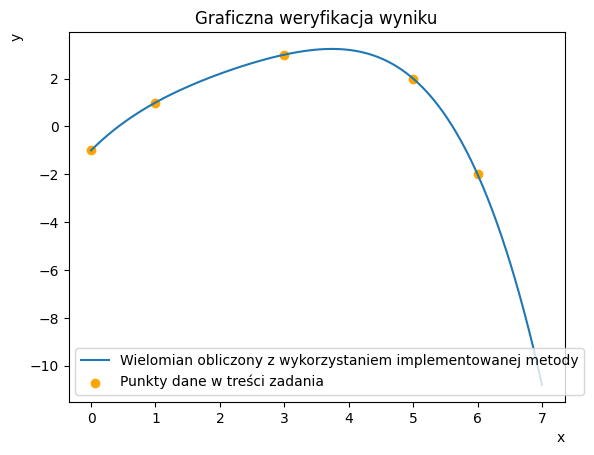

In [63]:
def fourth_deg_polynomial_coeffs_lst(x0):
    """
    Funkcja obliczająca wartości przy nieznanych współczynnikach wielomianu 4 stopnia, dla zadanego punktu.
    :param x0: Punkt, dla którego obliczane są wartości przy współczynnikach.
    :return: Funkcja zwraca listę wartości przy współczynnikach a_0, a_1, a_2, a_3 i a_4.
    """
    return [x0 ** i for i in range(5)]


def polynomial_value(lst_of_coeffs, x):
    """
    Funkcja obliczająca wartość wielomianu, dla zadanej listy współczynników oraz argumentów.
    :param lst_of_coeffs: Lista współczynników wielomianu, zaczynająca się od wyrazu wolnego.
    :param x: Argument / argumenty, dla których obliczana jest wartość wielomianu.
    :return: Funkcja zwraca listę argumentów i odpowiadających im wartości wielomianu.
    """
    y = np.zeros(len(x))
    for i in range(len(lst_of_coeffs)):
        y += lst_of_coeffs[i] * np.power(x, i)
    return x, y

points = [(0, -1), (1, 1), (3, 3), (5, 2), (6, -2)]
A = []
b = []
for x, y in points:
    A.append(fourth_deg_polynomial_coeffs_lst(x))
    b.append(y)

A = Matrix.create_from_list(A)
b = Vector(b)

coeffs = gaussian_solver(A, b)
print('Rozwiązania układu równań obliczone zaimplementowaną metodą:', '\n', coeffs, '\n')
print('Rozwiązania układu równań obliczone zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy):', '\n',
      np.array(coeffs), '\n')
print('Rozwiązania układu równań obliczone z użyciem biblioteki scipy:', '\n', scipy.linalg.solve(A, b), '\n')
print('Rozwiązania układu równań obliczone z użyciem biblioteki numpy:', '\n', np.linalg.solve(A, b))

x1 = np.linspace(0, 7, 1000)
plt.plot(*polynomial_value(coeffs, x1), label='Wielomian obliczony z wykorzystaniem implementowanej metody')
plt.scatter(*zip(*points), color='orange', label='Punkty dane w treści zadania')
plt.title('Graficzna weryfikacja wyniku')
plt.legend(loc='best')
plt.xlabel('x', loc='right')
plt.ylabel('y', loc='top')
plt.show()

### Zadanie 6

In [64]:
A = Matrix.create_from_list(
    [[3.50, 2.77, -0.76, 1.80],
     [-1.80, 2.68, 3.44, -0.09],
     [0.27, 5.07, 6.90, 1.61],
     [1.71, 5.45, 2.68, 1.71]])

b = Vector([7.31, 4.23, 13.85, 11.55])

x = gaussian_solver(A, b)
b1 = A.multiply_matrix_by_vector(x)
print('Wektor b obliczony zaimplementowaną metodą (jako iloczyn macierzy A i wektora rozwiązań x):', '\n', b1, '\n')
print('Wektor b obliczony zaimplementowaną metodą (po zamianie typu na tablicę z biblioteki numpy):', '\n', np.array(b1), '\n')
print('Wektor b', '\n', b)

Wektor b obliczony zaimplementowaną metodą (jako iloczyn macierzy A i wektora rozwiązań x): 
 <7.310000000000077, 4.2299999999999605, 13.850000000000003, 11.550000000000038> 

Wektor b obliczony zaimplementowaną metodą (po zamianie typu na tablicę z biblioteki numpy): 
 [ 7.31  4.23 13.85 11.55] 

Wektor b 
 <7.31, 4.23, 13.85, 11.55>


Wektor b obliczony jako iloczyn macierzy A i wektora rozwiązań x jest w zaokrągleniu do 13-14 miejsc po przecinku równy wektorowi b. Oznacza to, że metoda działa poprawnie dla tej macierzy, a rozwiązanie układu równań jest obliczone z dużą dokładnością.

Warto jednak zauważyć, że dokładność wyniku zależy także od standardu zapisu liczb zmiennoprzecinkowych, takiego jak IEEE 754, który ogranicza liczbę cyfr znaczących w obliczeniach numerycznych. W przypadku arytmetyki podwójnej precyzji (double precision) w standardzie IEEE 754 dokładność obliczeń wynosi około 15-17 cyfr znaczących. W związku z tym przy większych macierzach lub przy bardziej skomplikowanych operacjach numerycznych mogą wystąpić błędy zaokrągleń, które wpłyną na precyzję końcowego wyniku.

### Zadanie 7

In [65]:
A = Matrix.create_from_list(
    [[10, -2, -1, 2, 3, 1, -4, 7],
     [5, 11, 3, 10, -3, 3, 3, -4],
     [7, 12, 1, 5, 3, -12, 2, 3],
     [8, 7, -2, 1, 3, 2, 2, 4],
     [2, -15, -1, 1, 4, -1, 8, 3],
     [4, 2, 9, 1, 12, -1, 4, 1],
     [-1, 4, -7, -1, 1, 1, -1, -3],
     [-1, 3, 4, 1, 3, -4, 7, 6]])

b = Vector([0, 12, -5, 3, -25, -26, 9, -7])
x = gaussian_solver(A, b)

print('Rozwiązania układu równań obliczone zaimplementowaną metodą:', '\n', x, '\n')
print('Rozwiązania układu równań obliczone zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy):', '\n', np.array(x), '\n')
print('Rozwiązania układu równań obliczone z użyciem biblioteki scipy:', '\n', scipy.linalg.solve(A, b), '\n')
print('Rozwiązania układu równań obliczone z użyciem biblioteki numpy:', '\n', np.linalg.solve(A, b), '\n')

Rozwiązania układu równań obliczone zaimplementowaną metodą: 
 <-0.9999999999999982, 0.9999999999999997, -1.0000000000000018, 0.9999999999999991, -1.000000000000001, 0.9999999999999993, -0.9999999999999991, 0.9999999999999987> 

Rozwiązania układu równań obliczone zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy): 
 [-1.  1. -1.  1. -1.  1. -1.  1.] 

Rozwiązania układu równań obliczone z użyciem biblioteki scipy: 
 [-1.  1. -1.  1. -1.  1. -1.  1.] 

Rozwiązania układu równań obliczone z użyciem biblioteki numpy: 
 [-1.  1. -1.  1. -1.  1. -1.  1.] 



### Zadanie 8

In [66]:
A = Matrix.create_from_list(
        [[2, -1, 0, 0, 0, 0],
         [-1, 2, -1, 0, 0, 0],
         [0, -1, 2, -1, 0, 0],
         [0, 0, -1, 2, -1, 0],
         [0, 0, 0, -1, 2, -1],
         [0, 0, 0, 0, -1, 5]])

A_inversion = A.inv()

print('Macierz odwrotna obliczona zaimplementowaną metodą:', '\n', A_inversion, '\n')
print('Macierz odwrotna obliczona zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy, w celu lepszej wizualizacji):', '\n', np.array(A_inversion), '\n')
print('Macierz odwrotna obliczona metodą z biblioteki scipy:', '\n', scipy.linalg.inv(A), '\n')
print('Macierz odwrotna obliczona metodą z biblioteki numpy:', '\n', np.linalg.inv(A), '\n')

Macierz odwrotna obliczona zaimplementowaną metodą: 
 <0.84, 0.6799999999999999, 0.5199999999999999, 0.36, 0.19999999999999998, 0.04>
<0.6799999999999999, 1.3599999999999999, 1.0399999999999998, 0.72, 0.39999999999999997, 0.08>
<0.5199999999999999, 1.0399999999999998, 1.5599999999999998, 1.08, 0.6, 0.12000000000000001>
<0.35999999999999993, 0.7199999999999999, 1.0799999999999998, 1.4400000000000002, 0.8, 0.16000000000000003>
<0.19999999999999996, 0.3999999999999999, 0.6, 0.8, 1.0, 0.2>
<0.03999999999999999, 0.07999999999999997, 0.12, 0.16, 0.2, 0.24>
 

Macierz odwrotna obliczona zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy, w celu lepszej wizualizacji): 
 [[0.84 0.68 0.52 0.36 0.2  0.04]
 [0.68 1.36 1.04 0.72 0.4  0.08]
 [0.52 1.04 1.56 1.08 0.6  0.12]
 [0.36 0.72 1.08 1.44 0.8  0.16]
 [0.2  0.4  0.6  0.8  1.   0.2 ]
 [0.04 0.08 0.12 0.16 0.2  0.24]] 

Macierz odwrotna obliczona metodą z biblioteki scipy: 
 [[0.84 0.68 0.52 0.36 0.2  0.04]
 [0.68

Macierz odwrotna do podanej macierzy nie jest macierzą trójdiagonalną, niemniej jednak jest macierzą symetryczną (wartość w i-tym wierszu j-tej kolumny odpowiada wartości w j-tym wierszu i-tej kolumny: $A_{i, j} = A_{j, i}$). Macierz trójdiagonalna to taka, w której tylko elementy na głównej przekątnej oraz na sąsiednich przekątnych (nad i pod główną) są niezerowe. Innymi słowy, wszystkie elementy są równe zero, z wyjątkiem elementów na głównej przekątnej i dwóch przekątnych najbliższych głównej. W podanej macierzy występują niezerowe wartości również poza tymi trzema przekątnymi. 

Macierzą trójdiagonalną jest macierz A.

### Zadanie 9

In [67]:
A = [[1, 3, -9, 6, 4],
     [2, -1, 6, 7, 1],
     [3, 2, -3, 15, 5],
     [8, -1, 1, 4, 2],
     [11, 1, -2, 18, 7]]
A = Matrix.create_from_list(A)

A_inversion = A.inv()

print('Macierz odwrotna obliczona zaimplementowaną metodą:', '\n', A_inversion, '\n')
print('Macierz odwrotna obliczona zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy, w celu lepszej wizualizacji):', '\n', np.array(A_inversion), '\n')
print('Macierz odwrotna obliczona metodą z biblioteki scipy:', '\n', scipy.linalg.inv(A), '\n')
print('Macierz odwrotna obliczona metodą z biblioteki numpy:', '\n', np.linalg.inv(A), '\n')

print('Wartość wyznacznika macierzy obliczona zaimplementowaną metodą:', A.det())
print('Wartość wyznacznika macierzy obliczona metodą z biblioteki scipy:', np.linalg.det(A))
print('Wartość wyznacznika macierzy obliczona metodą z biblioteki numpy:', scipy.linalg.det(A))

Macierz odwrotna obliczona zaimplementowaną metodą: 
 <-46385389420483.625, -46385389420483.875, -46385389420481.75, -92770778840965.0, 92770778840965.25>
<-220330599747295.88, -220330599747296.34, -220330599747289.28, -440661199494584.7, 440661199494584.9>
<-36897468857202.3, -36897468857202.21, -36897468857201.93, -73794937714404.16, 73794937714404.16>
<-0.5, -0.5, 0.5, 0.0, 0.0>
<93824992236888.66, 93824992236889.0, 93824992236882.33, 187649984473770.44, -187649984473770.66>
 

Macierz odwrotna obliczona zaimplementowaną metodą (po zamianie typu rozwiązania na tablicę z biblioteki numpy, w celu lepszej wizualizacji): 
 [[-4.63853894e+13 -4.63853894e+13 -4.63853894e+13 -9.27707788e+13
   9.27707788e+13]
 [-2.20330600e+14 -2.20330600e+14 -2.20330600e+14 -4.40661199e+14
   4.40661199e+14]
 [-3.68974689e+13 -3.68974689e+13 -3.68974689e+13 -7.37949377e+13
   7.37949377e+13]
 [-5.00000000e-01 -5.00000000e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 9.38249922e+13  9.38249922e

Dana macierz jest macierzą osobliwą, co można sprawdzić, obliczając jej wyznacznik – jego wartość wynosi zero. W związku z tym macierz odwrotna do niej nie istnieje. Próby wyznaczenia macierzy odwrotnej, zarówno poprzez metodę implementowaną, jak i za pomocą bibliotek, prowadzą do niepoprawnych wyników. Elementy uzyskanej macierzy odwrotnej mają wartości bliskie zera lub są bardzo duże, co wskazuje, że jest to efekt błędu numerycznego przy obliczeniach.